In [1]:
# Import main libraries
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from IPython.display import display

# Import necessary gates for QZE fix and basis measurement
from qiskit.circuit.library import XGate, ZGate, HGate

# Import noise model components
from qiskit_aer.noise import NoiseModel, pauli_error, depolarizing_error
import matplotlib.colors as mcolors # For heatmap normalization

# --- Constants ---
N_QUBITS = 200 # Number of qubits for simulations
N_ZENO_STEPS_FIXED = 10 # Fixed number of Zeno steps for comparison graphs
NOISE_LEVEL_FIXED = 0.25 # Fixed noise level for comparing N_steps

/var/folders/x6/c44jk2f54jl2th8706q9sv500000gn/T/ipykernel_6821/2245516533.py:4: DeprecationWarning: Using Qiskit with Python 3.9 is deprecated as of the 2.1.0 release. Support for running Qiskit with Python 3.9 will be removed in the 2.3.0 release, which coincides with when Python 3.9 goes end of life.
  from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister


In [2]:
def get_alice_choices(n):
    """Generate Alice's random bits and bases."""
    bits = np.random.randint(2, size=n)
    bases = np.random.randint(2, size=n) # 0 for Z-basis, 1 for X-basis
    return bits, bases

def get_bob_choices(n):
    """Generate Bob's random bases."""
    bases = np.random.randint(2, size=n) # 0 for Z-basis, 1 for X-basis
    return bases

def sift_keys(alice_bases, bob_bases, alice_bits, bob_bits):
    """Sift the keys to keep only bits where bases matched."""
    sift_indices = np.where(alice_bases == bob_bases)[0]
    sifted_alice = alice_bits[sift_indices]
    sifted_bob = bob_bits[sift_indices]
    return sifted_alice, sifted_bob

def calculate_qber(alice_key, bob_key):
    """Calculates the Quantum Bit Error Rate."""
    if len(alice_key) == 0:
        return 0
    mismatches = np.sum(alice_key != bob_key)
    qber = mismatches / len(alice_key)
    return qber

print("Basic BB84 helper functions defined.")

Basic BB84 helper functions defined.


In [3]:
def get_aer_bit_flip_noise(p_noise):
    """Returns an Aer NoiseModel for Bit Flip (X) error applied to 'id'."""
    if p_noise <= 0: # Return None if no noise
        return None
    # X error with probability p_noise
    error = pauli_error([('X', p_noise), ('I', 1 - p_noise)])
    noise_model = NoiseModel()
    # The 'id' gate is used as a placeholder for channel time
    noise_model.add_all_qubit_quantum_error(error, ['id'])
    return noise_model

def get_aer_phase_flip_noise(p_noise):
    """Returns an Aer NoiseModel for Phase Flip (Z) error applied to 'id'."""
    if p_noise <= 0:
        return None
    # Z error with probability p_noise
    error = pauli_error([('Z', p_noise), ('I', 1 - p_noise)])
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ['id'])
    return noise_model

def get_aer_depolarizing_noise(p_noise):
    """Returns an Aer NoiseModel for Depolarizing error applied to 'id'."""
    if p_noise <= 0:
        return None
    # 1-qubit depolarizing error with probability p_noise
    error = depolarizing_error(p_noise, 1)
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ['id'])
    return noise_model

print("AerSimulator NoiseModel functions defined.")

AerSimulator NoiseModel functions defined.


In [4]:
def build_clean_bb84_circ(alice_bit, alice_basis, bob_basis):
    """Builds a 'clean' standard BB84 circuit with one channel placeholder."""
    qr = QuantumRegister(1, 'q')
    cr = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(qr, cr)

    # 1. Alice prepares her qubit
    if alice_bit == 1:
        qc.x(0)
    if alice_basis == 1: # X-basis
        qc.h(0)

    qc.barrier(label='Alice Prep')

    # 2. Channel: Identity gate acts as a placeholder for external noise
    qc.id(0)

    qc.barrier(label='Bob Receives')

    # 3. Bob measures the qubit
    if bob_basis == 1: # X-basis
        qc.h(0)
    qc.measure(0, 0)

    return qc

def run_standard_bb84_aer_noise(n_qubits, noise_model):
    """Simulates standard BB84 using a clean circuit and an Aer NoiseModel."""
    alice_bits, alice_bases = get_alice_choices(n_qubits)
    bob_bases = get_bob_choices(n_qubits)

    # Set up simulator
    simulator = AerSimulator(noise_model=noise_model) if noise_model else AerSimulator()

    bob_bits = []

    for i in range(n_qubits):
        qc = build_clean_bb84_circ(alice_bits[i], alice_bases[i], bob_bases[i])
        
        # Run simulation with 1 shot
        job = simulator.run(qc, shots=1, memory=True)
        result = job.result()
        # memory=True returns a list of result strings (e.g., ['0'] or ['1'])
        measured_bit = int(result.get_memory()[0]) 
        bob_bits.append(measured_bit)

    bob_bits = np.array(bob_bits)
    sifted_alice, sifted_bob = sift_keys(alice_bases, bob_bases, alice_bits, bob_bits)
    qber = calculate_qber(sifted_alice, sifted_bob)

    return qber

print("Standard BB84 functions (Aer Noise Model) defined.")

Standard BB84 functions (Aer Noise Model) defined.


Running Standard BB84 (Aer Noise Model) for 15 noise levels (N=200)...
Simulations complete. Plotting...


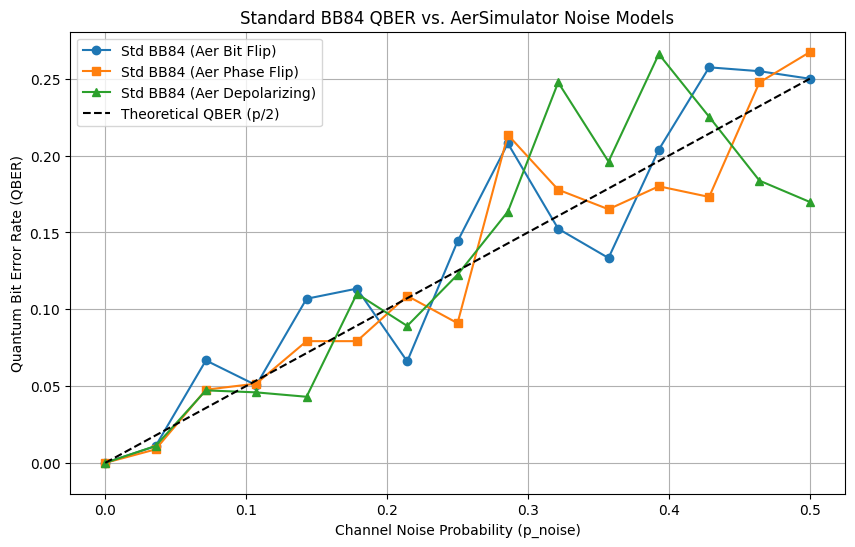

In [5]:
noise_levels_std_aer = np.linspace(0, 0.5, 15)
qber_std_aer_bf = []
qber_std_aer_pf = []
qber_std_aer_dp = []

print(f"Running Standard BB84 (Aer Noise Model) for {len(noise_levels_std_aer)} noise levels (N={N_QUBITS})...")

for p in noise_levels_std_aer:
    # Bit Flip Noise
    bf_model = get_aer_bit_flip_noise(p)
    qber_bf = run_standard_bb84_aer_noise(N_QUBITS, bf_model)
    qber_std_aer_bf.append(qber_bf)

    # Phase Flip Noise
    pf_model = get_aer_phase_flip_noise(p)
    qber_pf = run_standard_bb84_aer_noise(N_QUBITS, pf_model)
    qber_std_aer_pf.append(qber_pf)

    # Depolarizing Noise
    dp_model = get_aer_depolarizing_noise(p)
    qber_dp = run_standard_bb84_aer_noise(N_QUBITS, dp_model)
    qber_std_aer_dp.append(qber_dp)

print("Simulations complete. Plotting...")

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(noise_levels_std_aer, qber_std_aer_bf, 'o-', label='Std BB84 (Aer Bit Flip)')
plt.plot(noise_levels_std_aer, qber_std_aer_pf, 's-', label='Std BB84 (Aer Phase Flip)')
plt.plot(noise_levels_std_aer, qber_std_aer_dp, '^-', label='Std BB84 (Aer Depolarizing)')

# Theoretical line for comparison (QBER = p/2)
plt.plot(noise_levels_std_aer, 0.5 * noise_levels_std_aer, 'k--', label='Theoretical QBER (p/2)')
plt.xlabel('Channel Noise Probability (p_noise)')
plt.ylabel('Quantum Bit Error Rate (QBER)')
plt.title('Standard BB84 QBER vs. AerSimulator Noise Models')
plt.legend()
plt.grid(True)
plt.ylim(bottom=-0.02)
plt.show()

In [7]:
def run_qze_bb84_aer_noise(n_qubits, p_noise, n_zeno_steps, noise_type='bit_flip'):
    """Simulates the QZE-enhanced BB84 protocol using a clean circuit and Aer NoiseModel."""
    alice_bits, alice_bases = get_alice_choices(n_qubits)
    bob_bases = get_bob_choices(n_qubits)

    # --- Create Noise Model (Scaled) ---
    # The total channel noise p_noise is divided across n_steps_for_noise identity gates.
    n_steps_for_noise = max(1, n_zeno_steps)
    p_step = p_noise / n_steps_for_noise if n_steps_for_noise > 0 else 0

    noise_model = None
    if p_step > 0:
        if noise_type == 'bit_flip':
            noise_model = get_aer_bit_flip_noise(p_step)
        elif noise_type == 'phase_flip':
            noise_model = get_aer_phase_flip_noise(p_step)
        else: # depolarizing
            noise_model = get_aer_depolarizing_noise(p_step)
    # --- End Noise Model Creation ---

    simulator = AerSimulator(noise_model=noise_model) if noise_model else AerSimulator()
    bob_bits = []

    for i in range(n_qubits):
        qc = build_qze_bb84_circ_clean(
            alice_bits[i], alice_bases[i], bob_bases[i], n_zeno_steps
        )
        
        job = simulator.run(qc, shots=1, memory=True)
        result = job.result()
        # The memory string is returned (e.g., '011'). 
        # Bob's final measurement is explicitly directed to classical bit 0 (the first character in memory string).
        memory_str = result.get_memory()[0] 
        measured_bob_bit = int(memory_str[-1]) # Corrected: Measure into cr_all[0] means it is the LSB, thus the last character of the result string
        bob_bits.append(measured_bob_bit)

    bob_bits = np.array(bob_bits)
    sifted_alice, sifted_bob = sift_keys(alice_bases, bob_bases, alice_bits, bob_bits)
    qber = calculate_qber(sifted_alice, sifted_bob)

    return qber

print("QZE BB84 simulation function (Aer Noise Model) defined.")

QZE BB84 simulation function (Aer Noise Model) defined.


In [8]:
# --- Simulation Parameters ---
noise_levels_qze_aer = np.linspace(0, 0.5, 15)
zeno_steps_range = np.arange(1, 16) # 1 to 15 steps (used for fixed noise/varying steps)
zeno_steps_fixed_comp = [1, N_ZENO_STEPS_FIXED] # N=1 (Std) and N=10 (QZE) for fixed steps/varying noise plot
fixed_noise_levels_comp = [0.1, NOISE_LEVEL_FIXED, 0.4] # Used for fixed noise/varying steps plot
noise_types_aer = ['bit_flip', 'phase_flip', 'depolarizing']

# Data structures to store results
qber_results_vs_p = {ntype: {n: [] for n in zeno_steps_fixed_comp} for ntype in noise_types_aer}
qber_vs_n = {ntype: {p: [] for p in fixed_noise_levels_comp} for ntype in noise_types_aer}

print(f"Running comprehensive QZE BB84 simulations (N_qubits={N_QUBITS})...")

# 1. Simulate for Varying Noise (Fixed Steps) - Used for Cell 9
for ntype in noise_types_aer:
    print(f" Simulating {ntype} vs p_noise...")
    for n in zeno_steps_fixed_comp:
        for p in noise_levels_qze_aer:
            qber = run_qze_bb84_aer_noise(N_QUBITS, p, n, noise_type=ntype)
            qber_results_vs_p[ntype][n].append(qber)

# 2. Simulate for Varying Steps (Fixed Noise) - Used for Cell 10
for ntype in noise_types_aer:
    print(f" Simulating {ntype} vs N_steps...")
    for p in fixed_noise_levels_comp:
        for n in zeno_steps_range:
            qber = run_qze_bb84_aer_noise(N_QUBITS, p, n, noise_type=ntype)
            qber_vs_n[ntype][p].append(qber)

print("All simulations complete.")

Running comprehensive QZE BB84 simulations (N_qubits=200)...
 Simulating bit_flip vs p_noise...
 Simulating phase_flip vs p_noise...
 Simulating depolarizing vs p_noise...
 Simulating bit_flip vs N_steps...
 Simulating phase_flip vs N_steps...
 Simulating depolarizing vs N_steps...
All simulations complete.


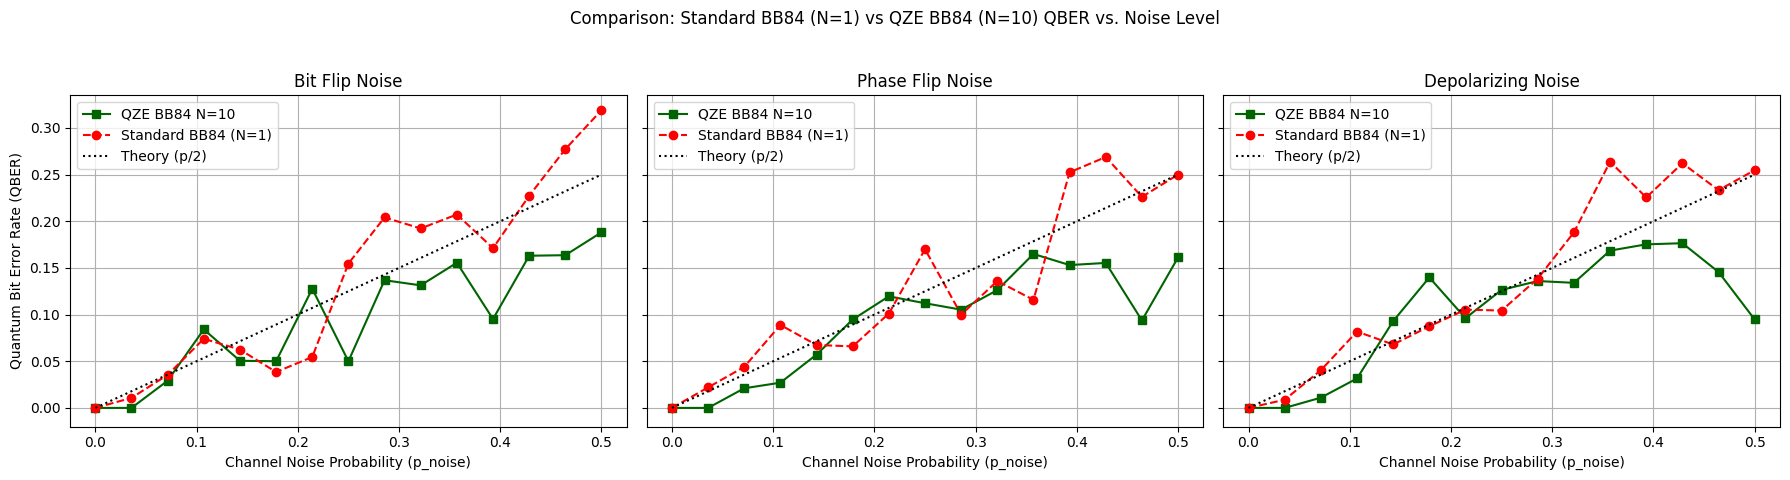

In [9]:
fixed_zeno_steps_comp = N_ZENO_STEPS_FIXED # 10

fig_comp_p, axes_comp_p = plt.subplots(1, len(noise_types_aer), figsize=(18, 5), sharey=True)
fig_comp_p.suptitle(f'Comparison: Standard BB84 (N=1) vs QZE BB84 (N={fixed_zeno_steps_comp}) QBER vs. Noise Level')

# Get the QBER results for N=1 (Standard) and N=10 (QZE)
qber_std_aer_comp = {ntype: qber_results_vs_p[ntype][1] for ntype in noise_types_aer}
qber_qze_aer_comp = {ntype: qber_results_vs_p[ntype][fixed_zeno_steps_comp] for ntype in noise_types_aer}

for idx, ntype in enumerate(noise_types_aer):
    ax_comp = axes_comp_p[idx]

    # Plot QZE-BB84 (Enhanced)
    ax_comp.plot(noise_levels_qze_aer, qber_qze_aer_comp[ntype], 's-', color='darkgreen', label=f'QZE BB84 N={fixed_zeno_steps_comp}')

    # Plot Standard BB84 (N=1)
    ax_comp.plot(noise_levels_qze_aer, qber_std_aer_comp[ntype], 'o--', color='red', label='Standard BB84 (N=1)')

    # Theoretical line
    ax_comp.plot(noise_levels_qze_aer, 0.5 * noise_levels_qze_aer, 'k:', label='Theory (p/2)')

    ax_comp.set_xlabel('Channel Noise Probability (p_noise)')
    if idx == 0:
      ax_comp.set_ylabel('Quantum Bit Error Rate (QBER)')
    ax_comp.set_title(f'{ntype.replace("_", " ").title()} Noise')
    ax_comp.legend()
    ax_comp.grid(True)
    ax_comp.set_ylim(bottom=-0.02)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

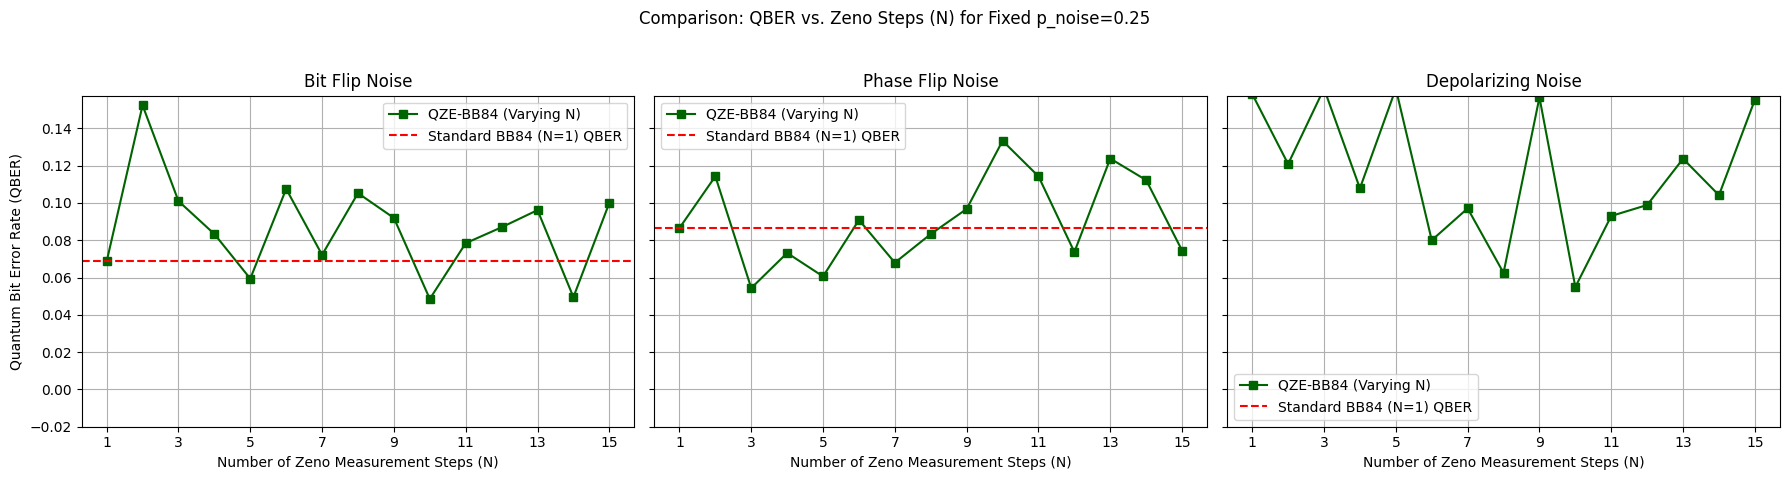

In [10]:
fixed_noise_level_comp = NOISE_LEVEL_FIXED # 0.25
zeno_steps_range_plot = np.arange(1, 16) # 1 to 15 steps

fig_comp_n, axes_comp_n = plt.subplots(1, len(noise_types_aer), figsize=(18, 5), sharey=True)
fig_comp_n.suptitle(f'Comparison: QBER vs. Zeno Steps (N) for Fixed p_noise={fixed_noise_level_comp}')

for idx, ntype in enumerate(noise_types_aer):
    ax_comp = axes_comp_n[idx]

    # QZE-BB84 curve (varying N steps)
    qber_qze_vs_n_fixed_p = qber_vs_n[ntype][fixed_noise_level_comp]
    ax_comp.plot(zeno_steps_range_plot, qber_qze_vs_n_fixed_p, 's-', color='darkgreen', label='QZE-BB84 (Varying N)')

    # Standard BB84 (N=1) QBER - represented by a horizontal line
    qber_std_n1 = qber_qze_vs_n_fixed_p[0] # QBER at N=1
    ax_comp.axhline(y=qber_std_n1, color='red', linestyle='--', label=f'Standard BB84 (N=1) QBER')

    ax_comp.set_xlabel('Number of Zeno Measurement Steps (N)')
    if idx == 0:
      ax_comp.set_ylabel('Quantum Bit Error Rate (QBER)')
    ax_comp.set_title(f'{ntype.replace("_", " ").title()} Noise')
    ax_comp.legend()
    ax_comp.grid(True)
    ax_comp.set_xticks(zeno_steps_range_plot[::2])
    ax_comp.set_ylim(bottom=-0.02)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Running heatmap simulations (Sims=150, N_qubits=100)...
Simulations complete. Plotting heatmap...


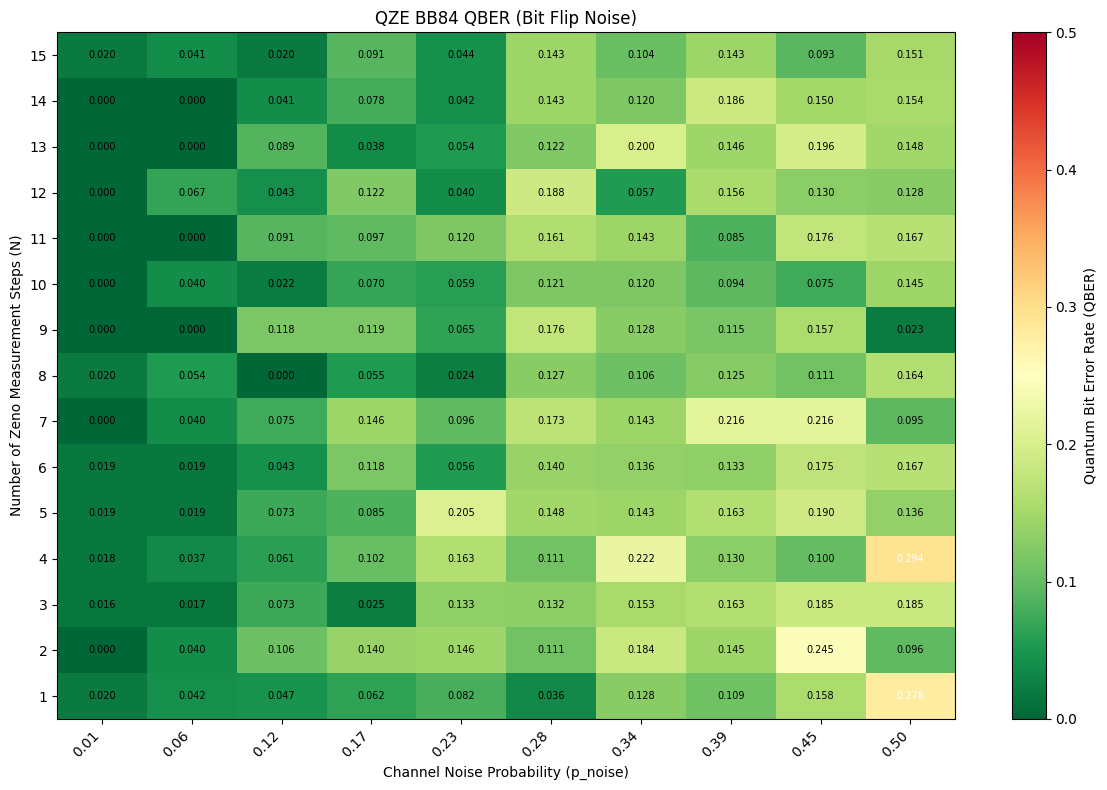

In [12]:
# --- Heatmap Simulation ---
N_QUBITS_HEATMAP = 100 # Using fewer qubits for this more intensive simulation
noise_levels_h = np.linspace(0.01, 0.5, 10) # 10 noise levels (p_noise)
zeno_steps_h = np.arange(1, 16) # 1 to 15 steps (N)
noise_type_heatmap = 'bit_flip' # Focusing the heatmap on Bit Flip Noise

qber_grid = np.zeros((len(zeno_steps_h), len(noise_levels_h)))

print(f"Running heatmap simulations (Sims={len(noise_levels_h) * len(zeno_steps_h)}, N_qubits={N_QUBITS_HEATMAP})...")

# Run the simulations to generate the QBER data grid
for i, n in enumerate(zeno_steps_h):
    for j, p in enumerate(noise_levels_h):
        # The run function is assumed to be defined in Cell 7
        qber = run_qze_bb84_aer_noise(N_QUBITS_HEATMAP, p, n, noise_type=noise_type_heatmap)
        qber_grid[i, j] = qber

print("Simulations complete. Plotting heatmap...")

# --- Plot the heatmap ---
plt.figure(figsize=(12, 8)) # Increased size for better readability of numbers

# Calculate the width of one noise step for centering the extent
dp = noise_levels_h[1] - noise_levels_h[0] if len(noise_levels_h) > 1 else 0.05
extent_p_start = noise_levels_h[0] - dp / 2
extent_p_end = noise_levels_h[-1] + dp / 2

# Normalize color map to better distinguish low QBER values, cap at 0.5 (max theoretical error)
norm = mcolors.Normalize(vmin=0, vmax=0.5)
plt.imshow(qber_grid, aspect='auto', interpolation='nearest',
           origin='lower', cmap='RdYlGn_r', norm=norm, # Use reversed Red-Yellow-Green map (Green=Low QBER)
           extent=[extent_p_start, extent_p_end, zeno_steps_h[0]-0.5, zeno_steps_h[-1]+0.5]) 
                   
# Set X-axis ticks to be exactly the noise level values
plt.xticks(noise_levels_h, [f'{p:.2f}' for p in noise_levels_h], rotation=45, ha='right')

# Add QBER value annotations in each box
for i in range(len(zeno_steps_h)):
    for j in range(len(noise_levels_h)):
        qber = qber_grid[i, j]
        p_noise_center = noise_levels_h[j]
        n_step_center = zeno_steps_h[i]
        
        # Choose text color based on background (QBER value) for readability
        # Light text for dark cells (high QBER), dark text for light cells (low QBER)
        text_color = "white" if qber > 0.25 else "black"
        
        plt.text(p_noise_center, n_step_center, 
                 f'{qber:.3f}', 
                 ha='center', va='center', 
                 color=text_color, fontsize=7) # Smaller font size to fit

plt.colorbar(label='Quantum Bit Error Rate (QBER)')
plt.xlabel('Channel Noise Probability (p_noise)')
plt.ylabel('Number of Zeno Measurement Steps (N)')
plt.title(f'QZE BB84 QBER ({noise_type_heatmap.replace("_"," ").title()} Noise)')
# Set Y-axis ticks to match the actual step numbers
plt.yticks(zeno_steps_h) 
plt.tight_layout()
plt.show()